In [471]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pandas as pd
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [472]:
data_processed = pd.read_csv('tweets_preprocessed2.csv')
non_suicide_data = data_processed[data_processed['class'] == 'non-suicide'].sample(n=500)
suicide_data = data_processed[data_processed['class'] == 'suicide'].sample(n=500)
balanced_data = pd.concat([non_suicide_data, suicide_data])

## Data Preprocessing

In [473]:
all_tokens = set(i.lower() for token in balanced_data["text"] for i in word_tokenize(token))
word_map = {token: idx for idx, token in enumerate(list(all_tokens))}
word_map['UNK'] = len(word_map)
word_map['PAD'] = len(word_map)+1
word_map

{'non-binary': 0,
 'bizarre': 1,
 'must': 2,
 'rotisserie': 3,
 'shore': 4,
 'happyi': 5,
 'two': 6,
 'both': 7,
 'kiss': 8,
 'weakness': 9,
 'suffering': 10,
 'exposing': 11,
 'noticedi': 12,
 '\\': 13,
 'at': 14,
 'remained': 15,
 'before-': 16,
 'girl': 17,
 'hype': 18,
 'response/selfishness': 19,
 'independent': 20,
 '9th': 21,
 'imagine': 22,
 'bubble': 23,
 'hung': 24,
 'phd': 25,
 'futures': 26,
 'alcohol': 27,
 '1am': 28,
 'everyones': 29,
 'he': 30,
 'cycle': 31,
 'nurse': 32,
 'faces': 33,
 'enternal': 34,
 'types': 35,
 'lane': 36,
 'reminder': 37,
 'came': 38,
 '2000': 39,
 'importance': 40,
 'whiny': 41,
 'never': 42,
 'offer': 43,
 'coughing': 44,
 'scaring': 45,
 'gambling': 46,
 'remarks': 47,
 'upcoming': 48,
 'lying': 49,
 'guidelines': 50,
 'stood': 51,
 'beer': 52,
 'brim': 53,
 'driveway': 54,
 'remove': 55,
 'irrational': 56,
 'eventual': 57,
 'maths': 58,
 'todaymy': 59,
 'walmart': 60,
 'pity': 61,
 'lite': 62,
 'mega': 63,
 'filled': 64,
 'drove': 65,
 'hundre

In [474]:
def text_encoder(sentence, word_map):
    tokens = word_tokenize(sentence.lower())
    encode = [word_map.get(token, word_map['UNK']) for token in tokens]
    return encode

In [475]:
class SuicideDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = sentences
        self.vocab = vocab
        self.label_mapping = {
            'non-suicide': 0,
            'suicide': 1
        }
        self.labels = [self.label_mapping[label] for label in labels]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]
        encoded_sentence = text_encoder(sentence, self.vocab)
        
        return {
            'input_ids': torch.tensor(encoded_sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [476]:
# Pad the input_ids to the length of the longest sequence in the batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['label'] for item in batch]

    
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=word_map['PAD'])
    labels = torch.stack(labels)
    text_lengths = torch.tensor([len(ids) for ids in input_ids], dtype=torch.long)
        
    return {
        'input_ids': padded_input_ids,
        'label': labels,
        'text_length': text_lengths
    }

In [477]:
# Split data
train_data, test_data, train_label, test_label = train_test_split(
    balanced_data['text'], balanced_data['class'], test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = SuicideDataset(train_data.to_numpy(), train_label.to_numpy(), word_map)
test_dataset = SuicideDataset(test_data.to_numpy(), test_label.to_numpy(), word_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

## LSTM Model

In [478]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab_size+1,embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid() # use sigmoid as activation function

    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True, enforce_sorted=False)
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)
        
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        hidden = self.batch_norm(hidden)
        outputs=self.sigmoid(self.fc(self.dropout(hidden)))
        
        return outputs

In [479]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 2  # suicidal/non-suicidal
n_layers = 2
bidirectional = True
dropout = 0.3

In [480]:
model = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [481]:
def accuracy(preds, y):
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [482]:
def train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    model.train()
    
    for batch in loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy(outputs, labels)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [483]:
def evaluate(model,loader,criterion): 
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            text_length = batch['text_length'].to(device)
            
            outputs = model(input_ids, text_length)

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [484]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []

for epoch in range(1,EPOCH_NUMBER+1):
    
    train_loss,train_acc = train(model,train_loader,optimizer,criterion)
    
    valid_loss,valid_acc = evaluate(model,test_loader,criterion)
    
    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)
    
    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

Epoch 1
	Train Loss: 0.584 | Train Acc: 71.38%
	 Val. Loss: 0.617 |  Val. Acc: 67.79%

Epoch 2
	Train Loss: 0.492 | Train Acc: 81.12%
	 Val. Loss: 0.593 |  Val. Acc: 70.19%

Epoch 3
	Train Loss: 0.451 | Train Acc: 85.38%
	 Val. Loss: 0.511 |  Val. Acc: 79.81%

Epoch 4
	Train Loss: 0.401 | Train Acc: 91.88%
	 Val. Loss: 0.524 |  Val. Acc: 77.88%

Epoch 5
	Train Loss: 0.388 | Train Acc: 92.50%
	 Val. Loss: 0.489 |  Val. Acc: 82.69%

Epoch 6
	Train Loss: 0.368 | Train Acc: 94.88%
	 Val. Loss: 0.539 |  Val. Acc: 74.52%

Epoch 7
	Train Loss: 0.361 | Train Acc: 95.25%
	 Val. Loss: 0.499 |  Val. Acc: 80.29%

Epoch 8
	Train Loss: 0.356 | Train Acc: 95.75%
	 Val. Loss: 0.481 |  Val. Acc: 83.17%

Epoch 9
	Train Loss: 0.346 | Train Acc: 97.00%
	 Val. Loss: 0.496 |  Val. Acc: 82.21%

Epoch 10
	Train Loss: 0.423 | Train Acc: 89.12%
	 Val. Loss: 0.612 |  Val. Acc: 68.75%



In [485]:
print("The best validation accuracy:", round(max(v_acc), 2))

The best validation accuracy: 0.83


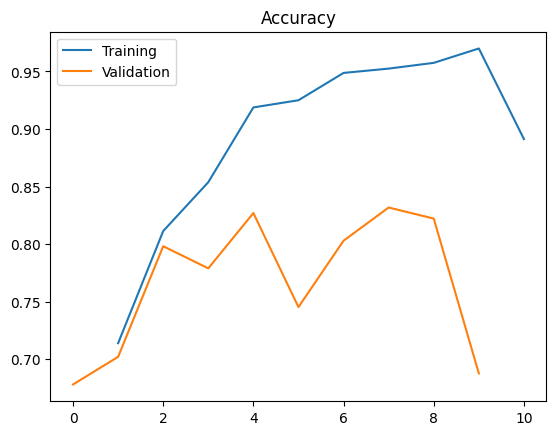

In [486]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
plt.title("Accuracy")
plt.legend(("Training", "Validation"))

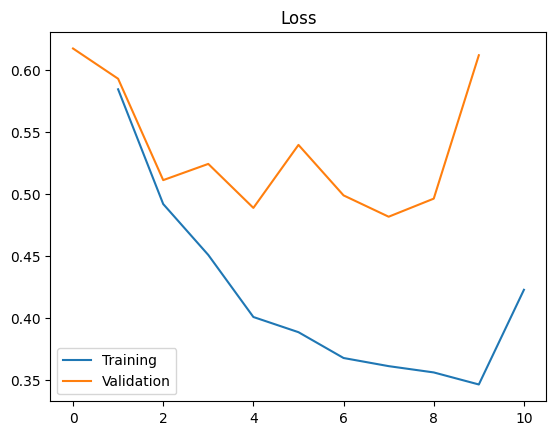

In [487]:
plt.plot(range(1, EPOCH_NUMBER+1), t_loss, v_loss)
plt.title("Loss")
plt.legend(("Training", "Validation"))

## Inference

In [488]:
def predict_sentence(sentence, model, word_map, device):
    # Preprocess the sentence
    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

    # Get the length of the input sentence (for packing sequence)
    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        prediction = torch.argmax(output, dim=1).item()  # Get the predicted class (0 or 1)

    # Interpret the result
    if prediction == 0:
        return "The sentence is classified as Non-Suicidal."
    else:
        return "The sentence is classified as Suicidal."

In [489]:
sentence = "I feel hopeless."
result = predict_sentence(sentence, model, word_map, device)
print(result)

The sentence is classified as Suicidal.
